In [2]:
import numpy as np
import mne

from hdf5storage import loadmat, savemat 
from mne.minimum_norm import make_inverse_operator, apply_inverse, compute_source_psd_epochs, write_inverse_operator

from matplotlib import pyplot as plt


In [3]:
outdict=loadmat('preprocessed_eeg.mat')
outdict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ch_bad', 'ch_dubious', 'ch_labels', 'chanlocs', 'preprocessed_eeg', 'subject_ID'])

In [4]:
preprocessed_eeg=outdict['preprocessed_eeg']*0.000001 # reduce the amplitube to be shown on MNE's plot
sampling_freq=outdict['Fs'][0]


In [5]:
ch_bad=[] # ch_bad=outdict['ch_bad'][0]-1
ch_dubious=[] # ch_dubious=outdict['ch_dubious'][0]-1

In [6]:

subject_ID=outdict['subject_ID'][0]

n_channels=np.shape(preprocessed_eeg)[0]
ch_info_bads=np.concatenate((ch_bad, ch_dubious), axis=0)
ch_info_bads=np.unique(ch_info_bads)


In [7]:
ch_labels=outdict['ch_labels'].tolist()

In [8]:
ch_labels_names=list()
for i in range(32):
    ch_labels_names.append(ch_labels[i][0][0])

In [9]:
ch_names = [f"E{n}" for n in range(1, 33)]


In [10]:
ch_types = ["eeg"] * n_channels
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage("GSN-HydroCel-32",match_case=False,match_alias=False,on_missing='raise', verbose=None)
info["description"] = subject_ID
print(info)

<Info | 9 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: 20220713
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 2000.0 Hz
>


In [11]:
info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

In [12]:
info['chs']

[{'loc': array([-0.02911661,  0.09968484,  0.03726501,  0.        ,  0.        ,
          0.        ,         nan,         nan,         nan,         nan,
                 nan,         nan]),
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'range': 1.0,
  'cal': 1.0,
  'kind': 2 (FIFFV_EEG_CH),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'ch_name': 'E1',
  'scanno': 1,
  'logno': 1},
 {'loc': array([0.02911661, 0.09968484, 0.03726501, 0.        , 0.        ,
         0.        ,        nan,        nan,        nan,        nan,
                nan,        nan]),
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'range': 1.0,
  'cal': 1.0,
  'kind': 2 (FIFFV_EEG_CH),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'ch_name': 'E2',
  'scanno': 2,
  'logno': 2},
 {'loc': array([-0.04817168,  0.07237926,  0.07553299,  0.        ,  0.        ,
          0.        ,         nan,         nan,         n

In [13]:
# alternative method 
# raw=mne.io.read_raw_fif('./TMSi32chan_loc_small_example.fif') # (this fif file is imported from original Poly5 to EDF to MNE)
# missing dig in the info

In [14]:
len(info['dig'])

35

In [15]:
outdict=loadmat('./xyzlabels.mat') # (this xyzlabels.mat has coordinates from original Poly to EDF to MNE)
x=outdict['x']
y=outdict['y']
z=outdict['z']
# this set of xyz does not look right to work as digitaization points for coregistartion, but works for topoplot
for ch in range(3,len(info['dig'])):
    info['dig'][ch]['r'][0]=x[ch-3]
    info['dig'][ch]['r'][1]=y[ch-3]
    info['dig'][ch]['r'][2]=z[ch-3]

In [16]:
info['dig']

[<DigPoint |        LPA : (-72.5, 0.0, 0.0) mm      : head frame>,
 <DigPoint |     Nasion : (0.0, 98.0, -0.0) mm      : head frame>,
 <DigPoint |        RPA : (72.5, 0.0, 0.0) mm       : head frame>,
 <DigPoint |     EEG #1 : (-29.3, 90.2, 6.3) mm     : head frame>,
 <DigPoint |     EEG #2 : (0.0, 94.6, 8.6) mm       : head frame>,
 <DigPoint |     EEG #3 : (29.3, 90.2, 6.3) mm      : head frame>,
 <DigPoint |     EEG #4 : (-76.8, 55.8, 2.7) mm     : head frame>,
 <DigPoint |     EEG #5 : (-50.3, 62.1, 51.4) mm    : head frame>,
 <DigPoint |     EEG #6 : (0.0, 63.7, 70.5) mm      : head frame>,
 <DigPoint |     EEG #7 : (50.3, 62.1, 51.4) mm     : head frame>,
 <DigPoint |     EEG #8 : (76.8, 55.8, 2.7) mm      : head frame>,
 <DigPoint |     EEG #9 : (-82.7, 31.7, 34.4) mm    : head frame>,
 <DigPoint |    EEG #10 : (-33.6, 33.6, 82.2) mm    : head frame>,
 <DigPoint |    EEG #11 : (33.6, 33.6, 82.2) mm     : head frame>,
 <DigPoint |    EEG #12 : (82.7, 31.7, 34.4) mm     : head fra

In [17]:
info['chs'][0]

{'loc': array([-0.02911661,  0.09968484,  0.03726501,  0.        ,  0.        ,
         0.        ,         nan,         nan,         nan,         nan,
                nan,         nan]),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'range': 1.0,
 'cal': 1.0,
 'kind': 2 (FIFFV_EEG_CH),
 'coil_type': 1 (FIFFV_COIL_EEG),
 'unit': 107 (FIFF_UNIT_V),
 'coord_frame': 4 (FIFFV_COORD_HEAD),
 'ch_name': 'E1',
 'scanno': 1,
 'logno': 1}

In [18]:
for ch in range(32):
    info['chs'][ch]['loc'][0]=x[ch]
    info['chs'][ch]['loc'][1]=y[ch]
    info['chs'][ch]['loc'][2]=z[ch]

In [19]:
info['chs'][0]

{'loc': array([-0.02929275,  0.09015381,  0.00626293,  0.        ,  0.        ,
         0.        ,         nan,         nan,         nan,         nan,
                nan,         nan]),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'range': 1.0,
 'cal': 1.0,
 'kind': 2 (FIFFV_EEG_CH),
 'coil_type': 1 (FIFFV_COIL_EEG),
 'unit': 107 (FIFF_UNIT_V),
 'coord_frame': 4 (FIFFV_COORD_HEAD),
 'ch_name': 'E1',
 'scanno': 1,
 'logno': 1}

In [20]:
# Coordinates=outdict['Coordianates']/1000
# for ch in range(3,len(info['dig'])):
#     info['dig'][ch]['r']=Coordinates[ch-3,:]

In [21]:
# mark the bad channels
ch_labels_info_bads=list()
for k in range(len(ch_info_bads)):
    ch_labels_info_bads.append(ch_names[ch_info_bads[k]])

info['bads'] = ch_labels_info_bads

In [22]:
raw = mne.io.RawArray(preprocessed_eeg, info)
raw.set_eeg_reference('average', projection=True)
# raw.plot(show_scrollbars=False, show_scalebars=False)

Creating RawArray with float64 data, n_channels=32, n_times=258122
    Range : 0 ... 258121 =      0.000 ...   129.060 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<RawArray | 32 x 258122 (129.1 s), ~63.1 MB, data loaded>

In [23]:
raw.save("raw.fif",overwrite=True)

Overwriting existing file.
Writing /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan/raw.fif
Closing /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan/raw.fif
[done]


In [24]:
fig = mne.viz.plot_alignment(
    raw.info)
mne.viz.set_3d_view(fig)

Using pyvistaqt 3d backend.



qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


Channel types::	eeg: 32


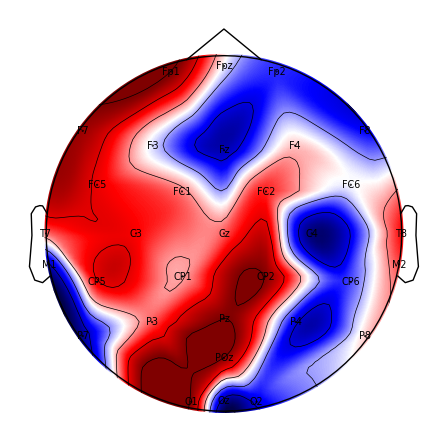

(<matplotlib.image.AxesImage at 0x7fe10f6f05b0>,
 <matplotlib.contour.QuadContourSet at 0x7fe10f6f0850>)

In [25]:
# topoplot
import numpy as np
x=np.random.rand(32)
x=list(x*100)
# x=list(range(1,33,1))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(x, \
    raw.info, vlim=(None, None), axes=ax,\
        sensors=True, names=ch_labels_names, cmap='seismic')

coregistration

In [26]:
# mne.gui.coregistration()

forward solution

In [27]:
# the raw file containing the channel location + types
raw_fname = './raw.fif'

# The paths to Freesurfer reconstructions
subjects_dir ='../../archive/subjects/'
subject = 'fsaverage' # change it to use freesurfer's bem

# Compute Source Space (surface)
ico = 4 #**************************************************************
spacing='ico'+str(ico) 
src = mne.setup_source_space(subject, spacing=spacing, add_dist='patch',
                             subjects_dir=subjects_dir)

conductivity = (0.3, 0.0075, 0.3)  #  three layers for EEG (MNE default  (0.3 0.006 0.3) )
model = mne.make_bem_model(subject=subject, ico=ico,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

trans = './egi_trans.fif'

fwd = mne.make_forward_solution(raw_fname, trans=trans, src=src, bem=bem,
                                meg=False, eeg=True, mindist=5.0, n_jobs=2,
                                verbose=True)
print(fwd)

# 1m 40s

Setting up the source space with the following parameters:

SUBJECTS_DIR = /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan/../../archive/subjects
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan/../../archive/subjects/fsaverage/surf/lh.white...
Mapping lh fsaverage -> ico (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan/../../archive/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 2562/163842 selected to source space (ico = 4)

Loading /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_32chan/../../archive/subjects/fsaverage/surf/rh.white...
Mapping rh fsaverage -> ico (4) ...
  

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    Found    0/1953 points outside using solid angles
    Total 2562/2562 points inside the surface
Interior check completed in 6225.5 ms
Checking surface interior status for 2562 points...
    Found  561/2562 points inside  an interior sphere of radius   47.7 mm
    Found    0/2562 points outside an exterior sphere of radius   98.3 mm
    Found    0/2001 points outside using surface Qhull


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    Found    0/2001 points outside using solid angles
    Total 2562/2562 points inside the surface
Interior check completed in 609.2 ms



[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished


Setting up for EEG...
Computing EEG at 5124 source locations (free orientations)...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.



Finished.
<Forward | MEG channels: 0 | EEG channels: 32 | Source space: Surface with 5124 vertices | Source orientation: Free>


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.9s finished


In [28]:
src

<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=2562>, <surface (rh), n_vertices=163842, n_used=2562>] MRI (surface RAS) coords, subject 'fsaverage', ~30.8 MB>

In [29]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
source_rr=fwd_fixed['source_rr']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 32 sensors x 5124 dipoles


In [30]:
mne.write_forward_solution('fwd.fif', fwd_fixed, overwrite=True, verbose=None)

Overwriting existing file.


/tmp/ipykernel_3426501/1225453021.py:1: RuntimeWarning: This filename (fwd.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  mne.write_forward_solution('fwd.fif', fwd_fixed, overwrite=True, verbose=None)


    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


/tmp/ipykernel_3426501/1225453021.py:1: RuntimeWarning: This forward solution is based on a forward solution with free orientation. The original forward solution is stored on disk in X/Y/Z RAS coordinates. Any transformation (surface orientation or fixed orientation) will be reverted. To reapply any transformation to the forward operator please apply convert_forward_solution after reading the forward solution with read_forward_solution.
  mne.write_forward_solution('fwd.fif', fwd_fixed, overwrite=True, verbose=None)


inv

In [31]:
# use the entire data as empty room noise
noise_cov = mne.compute_raw_covariance(raw)
noise_cov_mat=noise_cov['data']# it only included the good chans
# compute the average of the diagonal
# construct the scale of the noise cov
scale=0.05 # 1% 5% 10% 30% 50% *******************************************************************************
scale_ave=np.mean(noise_cov_mat.diagonal())*scale
sim_cov_mat=np.zeros((np.shape(noise_cov_mat)))
for i in range(np.shape(sim_cov_mat)[0]):
       sim_cov_mat[i,i]=scale_ave


Using up to 645 segments
Number of samples used : 258000
[done]


In [32]:
# plt.imshow(noise_cov_mat,vmin=-1.5e-10, vmax=1.5e-10, cmap='jet')
# plt.colorbar()
# np.mean(noise_cov_mat.diagonal())

In [33]:
sim_cov=noise_cov.copy()
sim_cov['data']=sim_cov_mat
# mne.write_cov('sim_cov.fif', sim_cov, overwrite=True, verbose=None)

In [34]:
nepochs=int(np.floor(np.shape(preprocessed_eeg)[1]/sampling_freq))
epochs_mat = np.column_stack(
    (
        np.arange(0, np.shape(preprocessed_eeg)[1], sampling_freq),
        np.zeros(nepochs, dtype=int),
        np.array([1]*nepochs),
    )
)

epoch_dict = dict(resting=1)
epochs = mne.Epochs(raw, epochs_mat, tmin=0, tmax=0.999, event_id=epoch_dict, preload=True, baseline=(None, None))

evoked = epochs["resting"].average()
mne.write_evokeds('resting_ave.fif', evoked, on_mismatch='raise', overwrite=True, verbose=None)
evokeds = mne.read_evokeds('./resting_ave.fif')
resting = evokeds[0]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 130 and the array at index 1 has size 129

In [35]:
# fwd = mne.read_forward_solution('fwd.fif')
mne.convert_forward_solution(fwd, surf_ori=True, copy=False)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]


Good channels,32 EEG
Bad channels,None
Source space,Surface with 5124 vertices
Source orientation,Free


In [36]:
# Compute the source estimate (Fixed dipole orientations)
# depth=0.8 # 0.8 1 2 4 ***************************************************************************************
inverse_operator = make_inverse_operator(resting.info, fwd, sim_cov, depth=depth, fixed=True)
# save the inverse operator and the inverse matrix
# write_inverse_operator('inv.fif', inverse_operator,overwrite=True)

NameError: name 'resting' is not defined

In [ ]:
%run extract_invmat.ipynb # run this script to load the functions needed to extract inverse matrix

In [ ]:
method = "MNE"  # (could also be dSPM or sLORETA)
invmat=_get_matrix_from_inverse_operator(inverse_operator,fwd,method=method,lambda2=1.0/9.0)
np.shape(invmat)

Correlation

In [ ]:
# remove bad channels from the original eeg
original_eeg=np.delete(preprocessed_eeg,ch_info_bads,0)

In [ ]:
# reconstruct eeg using invmat and leadfield matrix
source_data=np.matmul(invmat,original_eeg)
EEG_recon=np.matmul(leadfield,source_data)

In [ ]:
# remove bad channels from the reconstructed eeg
EEG_recon=np.delete(EEG_recon,ch_info_bads,0)

In [ ]:
# plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon.transpose())
# plt.title('reconstructed EEG - all chan')
# plt.ylim([-2e-5,2e-5])
# # 16 s

In [ ]:
# plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon[ch_dubious,:].transpose())
# plt.title('reconstructed EEG - dubious chan')
# plt.ylim([-2e-5,2e-5])

In [ ]:
# plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon[ch_bad,:].transpose())
# plt.title('reconstructed EEG - bad chan')
# plt.ylim([-2e-5,2e-5])

In [ ]:
# compute correlation
corr = np.corrcoef(EEG_recon, original_eeg, rowvar=True)

In [ ]:
# np.arange(0,np.shape(EEG_recon)[0],1)+194

In [ ]:
# corr=corr[np.arange(0,np.shape(EEG_recon)[0],1)]

In [ ]:
# np.shape(corr)

In [ ]:
# corr=corr[:,np.arange(194,388,1)]

In [ ]:
# plt.imshow(corr,cmap='jet',vmin=-1,vmax=1)
# plt.ylabel('reconstructed EEG (194 good channels)')
# plt.xlabel('original EEG (194 good channels)')
# plt.title('correlation')
# plt.colorbar()

In [ ]:
plt.imshow(corr,cmap='jet',vmin=-1,vmax=1)
plt.colorbar()
plt.title('corrceof: ico' + str(ico) + ' scale ' +str(scale) +' depth '+ str(depth))

In [ ]:
corrcoef_diag=np.zeros((np.shape(EEG_recon)[0]))
for i in range(np.shape(EEG_recon)[0]):
    corrcoef_diag[i]=corr[i,np.shape(EEG_recon)[0]+i]
plt.plot(np.arange(0, np.shape(EEG_recon)[0],1) ,corrcoef_diag, 'r.')
plt.title('corrceof: ico' + str(ico) + ' scale ' +str(scale) +' depth '+ str(depth))
plt.xlabel('good channels')
plt.ylabel('corrcoef')

In [ ]:
# # save outputs all in one mat file. 
# outdict=dict()
# outdict['leadfield']=leadfield # leadfield matrix
# outdict['invmat']=invmat #  inverse matrix
# outdict['source_rr']=source_rr # the source location AND labels (matlab)
# outdict['sim_cov_mat']=sim_cov_mat # noise covariance
# outdict['scale']=scale # scale
# outdict['depth']=depth # depth
# outdict['conductivity']=conductivity # 3 layrs conductivity


# outdict['ch_bad']=ch_bad #  inverse matrix
# outdict['ch_dubious']=ch_dubious # 
# outdict['ch_names']=ch_names #  
# outdict['Coordinates']=Coordinates #  
# outdict['corrcoef_diag']=corrcoef_diag #  
# outdict['subject_ID']=subject_ID #  

# savemat(subject_ID+'_scale_'+str(scale)+'_depth_'+str(depth),outdict)